In [48]:
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler


In [49]:
# Load dataset
df = pd.read_csv('../data/data.csv')

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Gender', 'Workout_Type'], drop_first=True)


In [50]:
# Basic info
print(df.shape)
print(df.info())
print(df["Fat_Percentage"].describe())

(973, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Weight (kg)                    973 non-null    float64
 2   Height (m)                     973 non-null    float64
 3   Max_BPM                        973 non-null    int64  
 4   Avg_BPM                        973 non-null    int64  
 5   Resting_BPM                    973 non-null    int64  
 6   Session_Duration (hours)       973 non-null    float64
 7   Calories_Burned                973 non-null    float64
 8   Fat_Percentage                 973 non-null    float64
 9   Water_Intake (liters)          973 non-null    float64
 10  Workout_Frequency (days/week)  973 non-null    int64  
 11  Experience_Level               973 non-null    int64  
 12  BMI                            973 non-n

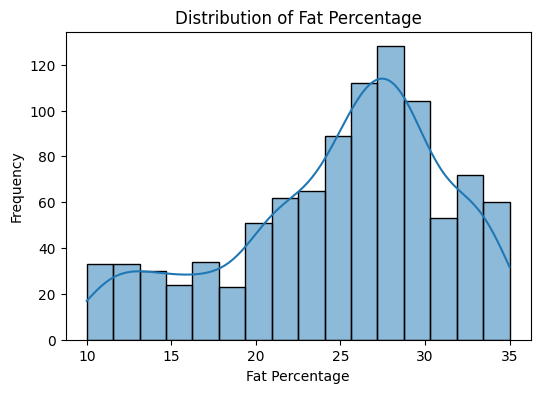

In [51]:
# Distribution plot
from matplotlib import pyplot as plt
import seaborn as sns 

plt.figure(figsize=(6, 4))
sns.histplot(df["Fat_Percentage"], kde=True)
plt.title("Distribution of Fat Percentage")
plt.xlabel("Fat Percentage")
plt.ylabel("Frequency")
plt.show()

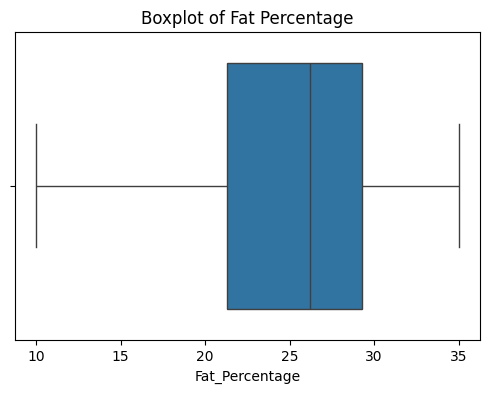

In [52]:
# Boxplot for outlier detection
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Fat_Percentage"])
plt.title("Boxplot of Fat Percentage")
plt.show()

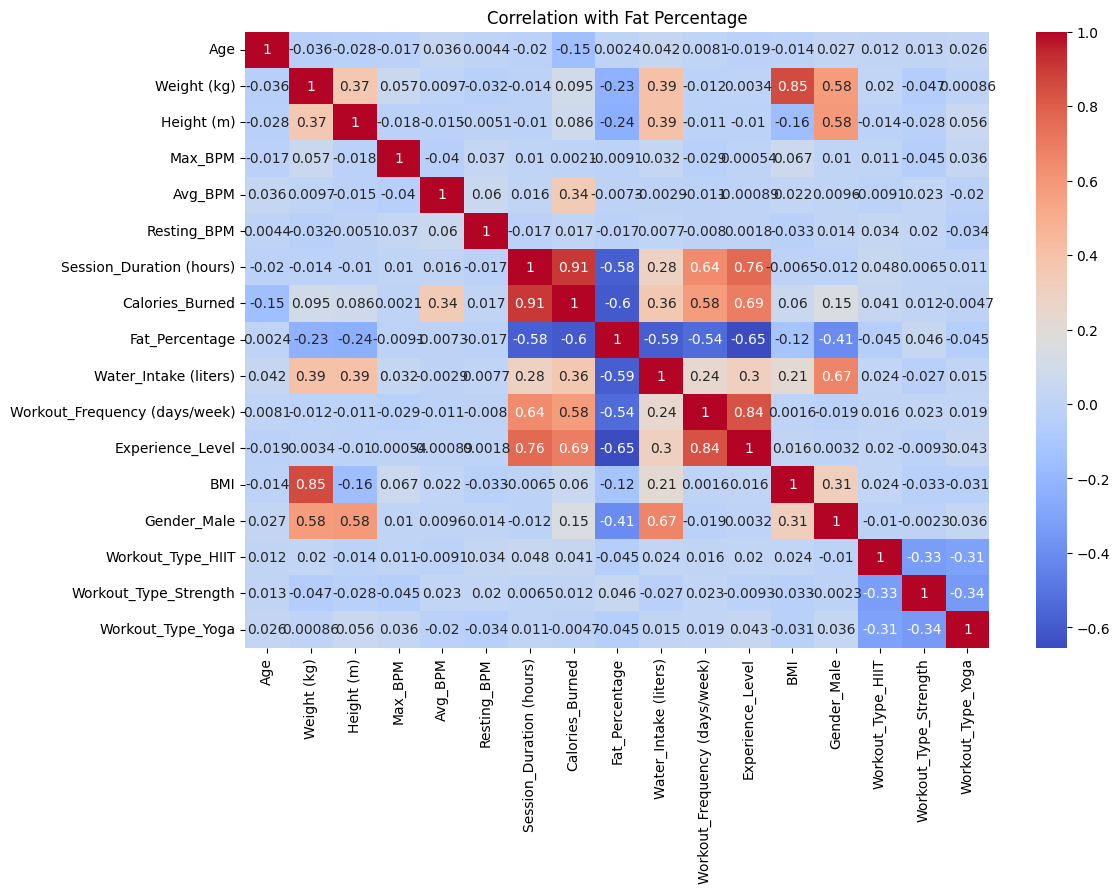

In [53]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation with Fat Percentage")
plt.show()

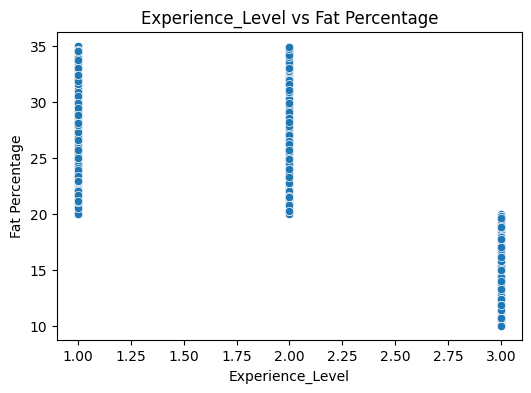

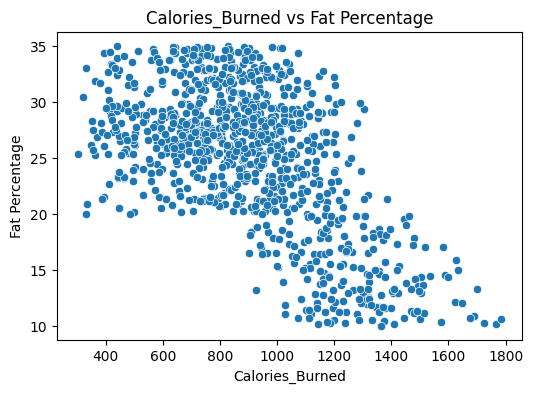

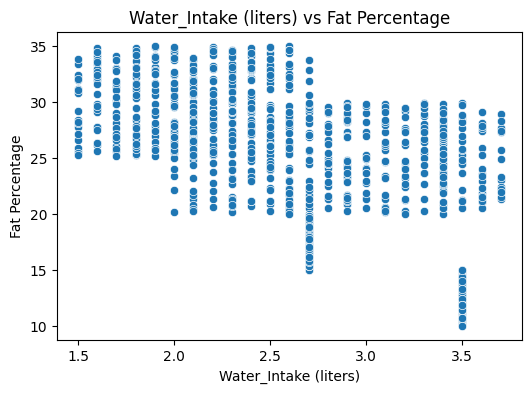

In [54]:
# Scatter plots with top correlated features
top_corr = df.corr(numeric_only=True)["Fat_Percentage"].abs().sort_values(ascending=False)[1:4]
for feature in top_corr.index:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df["Fat_Percentage"])
    plt.title(f"{feature} vs Fat Percentage")
    plt.xlabel(feature)
    plt.ylabel("Fat Percentage")
    plt.show()

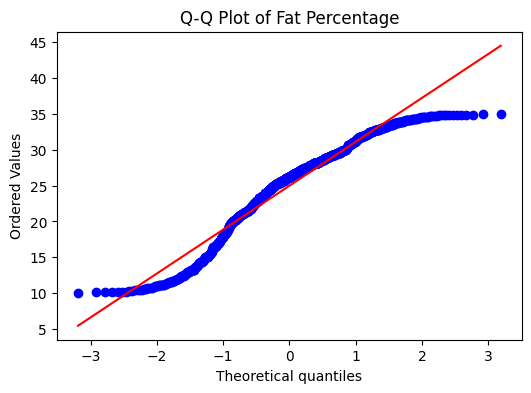

In [55]:
# Q-Q plot for normality
from scipy import stats


plt.figure(figsize=(6, 4))
stats.probplot(df["Fat_Percentage"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Fat Percentage")
plt.show()

In [56]:
# Define features and target
X = df.drop(columns=['Fat_Percentage'])
y = df['Fat_Percentage']

# Apply ANOVA F-test to select top 6 features
selector = SelectKBest(score_func=f_regression, k=6)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top features:", list(selected_features))


Top features: ['Session_Duration (hours)', 'Calories_Burned', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'Gender_Male']


In [57]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [58]:
# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 1.0],
    'min_samples_split': [2, 5]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    gbr, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 1.0}


In [59]:
# Retrieve best model from grid search
best_model = grid_search.best_estimator_




In [60]:
# Cross-validation R² and RMSE on training set
cv_r2 = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_rmse = np.sqrt(-cross_val_score(
    best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error'))

print(f"\nCross-Validation Training R2 (mean ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"Cross-Validation Training RMSE (mean ± std): {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")


Cross-Validation Training R2 (mean ± std): 0.7977 ± 0.0298
Cross-Validation Training RMSE (mean ± std): 2.7776 ± 0.0756


In [61]:
# Fit best model to full training data
best_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred)

print(f"\nTraining R2 Score: {train_r2:.4f}")
print(f"Training RMSE:     {train_rmse:.4f}")
print(f"Testing R2 Score:  {test_r2:.4f}")
print(f"Testing RMSE:      {test_rmse:.4f}")



Training R2 Score: 0.8207
Training RMSE:     7.0178
Testing R2 Score:  0.8059
Testing RMSE:      7.5904


Train RMSE: 2.6491
Test RMSE: 2.7551


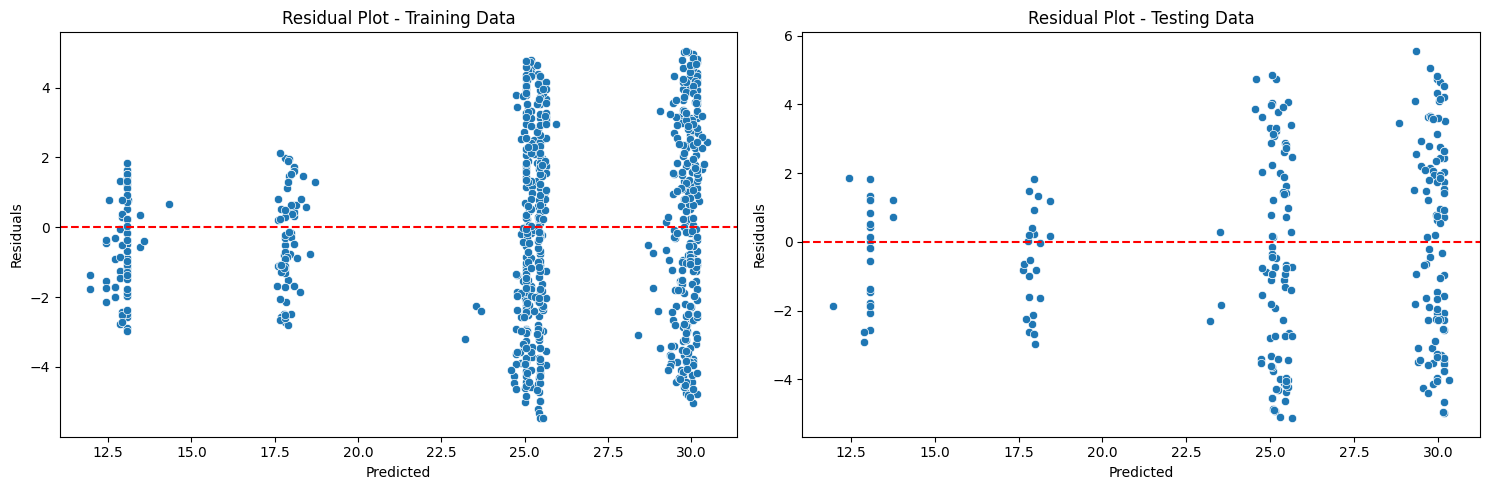

In [62]:
# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Plot residuals for train and test side by side
fig, axes = plt.subplots(1, 2, figsize=(15,5))

# Training residuals
sns.scatterplot(x=y_train_pred, y=residuals_train, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Residual Plot - Training Data")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residuals")

# Testing residuals
sns.scatterplot(x=y_test_pred, y=residuals_test, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title("Residual Plot - Testing Data")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

In [63]:


# Save the trained model, scaler, and selected features
joblib.dump(best_model, '../models/fat/fat-model.pkl')
joblib.dump(scaler, '../models/fat/fat-scaler.pkl')
joblib.dump(selected_features, '../models/fat/fat-selected_features.pkl')




['../models/fat/fat-selected_features.pkl']

In [64]:


# Your selected features from the model
selected_features = ['Session_Duration (hours)', 'Calories_Burned', 'Water_Intake (liters)', 
                     'Workout_Frequency (days/week)', 'Experience_Level', 'Gender_Male']

# Print selected features
print("Selected Features:", selected_features)

# Define 5 custom test samples as dicts
custom_tests = [
    {'Session_Duration (hours)': 1.2, 'Calories_Burned': 800, 'Water_Intake (liters)': 2.5,
     'Workout_Frequency (days/week)': 4, 'Experience_Level': 2, 'Gender_Male': 1},

    {'Session_Duration (hours)': 0.8, 'Calories_Burned': 500, 'Water_Intake (liters)': 1.8,
     'Workout_Frequency (days/week)': 3, 'Experience_Level': 1, 'Gender_Male': 0},

    {'Session_Duration (hours)': 1.5, 'Calories_Burned': 1100, 'Water_Intake (liters)': 3.0,
     'Workout_Frequency (days/week)': 5, 'Experience_Level': 3, 'Gender_Male': 1},

    {'Session_Duration (hours)': 0.5, 'Calories_Burned': 400, 'Water_Intake (liters)': 2.0,
     'Workout_Frequency (days/week)': 2, 'Experience_Level': 1, 'Gender_Male': 0},

    {'Session_Duration (hours)': 2.0, 'Calories_Burned': 1400, 'Water_Intake (liters)': 3.5,
     'Workout_Frequency (days/week)': 6, 'Experience_Level': 3, 'Gender_Male': 1},
]

# Convert to DataFrame
custom_df = pd.DataFrame(custom_tests)

# Ensure columns order matches selected_features
custom_df = custom_df[selected_features]

# Scale features (using your previously fitted scaler)
custom_scaled = scaler.transform(custom_df)

# Predict using your trained model (best_model)
predictions = best_model.predict(custom_scaled)

# Print only predicted results
for i, pred in enumerate(predictions, 1):
    print(f"Sample {i} - Predicted Fat Percentage: {pred:.2f}%")



Selected Features: ['Session_Duration (hours)', 'Calories_Burned', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'Gender_Male']
Sample 1 - Predicted Fat Percentage: 25.36%
Sample 2 - Predicted Fat Percentage: 30.14%
Sample 3 - Predicted Fat Percentage: 20.55%
Sample 4 - Predicted Fat Percentage: 29.48%
Sample 5 - Predicted Fat Percentage: 14.32%


c:\Users\yine6\OneDrive\Bureau\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
